# Lib importing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers

%matplotlib inline
%load_ext tensorboard

/usr/lib/python3/dist-packages/paramiko/transport.py:236: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
2022-11-30 19:34:12.972452: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-30 19:34:13.047369: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-30 19:34:13.047384: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-30 19:34:13.491152: W tensorflow/compiler/xla/stream_executor/platform/default/dso_lo

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Loading և preprocessing

In [3]:
CSV_FILE_PATH = "esc50.csv" 
DATA_PATH = "audio/audio/44100/"

In [4]:
df = pd.read_csv(CSV_FILE_PATH)
df

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A
...,...,...,...,...,...,...,...
1995,5-263831-B-6.wav,5,6,hen,False,263831,B
1996,5-263902-A-36.wav,5,36,vacuum_cleaner,False,263902,A
1997,5-51149-A-25.wav,5,25,footsteps,False,51149,A
1998,5-61635-A-8.wav,5,8,sheep,False,61635,A


50 class-ներից օգտագործելուց միայն 10ը։ datafram-ը ունի "esc10" column որն ունի 10 class, որն էլ և օգտագործելու ենք։

In [5]:
df_10 = df[df['esc10']==True]
df_10 = df_10.drop(['fold','esc10','src_file','take'], axis=1)
df_10

,filename,target,category
0,1-100032-A-0.wav,0,dog
14,1-110389-A-0.wav,0,dog
24,1-116765-A-41.wav,41,chainsaw
54,1-17150-A-12.wav,12,crackling_fire
55,1-172649-A-40.wav,40,helicopter
...,...,...,...
1876,5-233160-A-1.wav,1,rooster
1888,5-234879-A-1.wav,1,rooster
1889,5-234879-B-1.wav,1,rooster
1894,5-235671-A-38.wav,38,clock_tick


Թիրախային column-ը edit ենք անում համաձայն այդ 10 class-ների։

In [6]:
classes = df_10['category'].unique()
classes

array(['dog', 'chainsaw', 'crackling_fire', 'helicopter', 'rain',
       'crying_baby', 'clock_tick', 'sneezing', 'rooster', 'sea_waves'],
      dtype=object)

In [7]:
class_dict = {i:x for x,i in enumerate(classes)}
class_dict

{'dog': 0,
 'chainsaw': 1,
 'crackling_fire': 2,
 'helicopter': 3,
 'rain': 4,
 'crying_baby': 5,
 'clock_tick': 6,
 'sneezing': 7,
 'rooster': 8,
 'sea_waves': 9}

In [8]:
df_10['target'] = df_10['category'].map(class_dict)
df_10

,filename,target,category
0,1-100032-A-0.wav,0,dog
14,1-110389-A-0.wav,0,dog
24,1-116765-A-41.wav,1,chainsaw
54,1-17150-A-12.wav,2,crackling_fire
55,1-172649-A-40.wav,3,helicopter
...,...,...,...
1876,5-233160-A-1.wav,8,rooster
1888,5-234879-A-1.wav,8,rooster
1889,5-234879-B-1.wav,8,rooster
1894,5-235671-A-38.wav,6,clock_tick


# Վիզուալիզացիա

In [9]:
# from IPython.display import HTML

In [10]:
sample_df = df_10.drop_duplicates(subset=['target'])
sample_df

,filename,target,category
0,1-100032-A-0.wav,0,dog
24,1-116765-A-41.wav,1,chainsaw
54,1-17150-A-12.wav,2,crackling_fire
55,1-172649-A-40.wav,3,helicopter
62,1-17367-A-10.wav,4,rain
78,1-187207-A-20.wav,5,crying_baby
110,1-21934-A-38.wav,6,clock_tick
136,1-26143-A-21.wav,7,sneezing
141,1-26806-A-1.wav,8,rooster
148,1-28135-A-11.wav,9,sea_waves


In [11]:
signals = {}
mel_spectrograms = {}
mfccs = {}

for row in tqdm(sample_df.iterrows()):  # every row will be like [[index], [filename , target , category]]
    signal , rate = librosa.load(DATA_PATH+ row[1][0])
    signals[row[1][2]] = signal    # row[1][2] will be the category of that signal. eg. signal["dog"] = signal of dog sound
    
    mel_spec = librosa.feature.melspectrogram(y=signal , sr=rate ,  n_fft=2048, hop_length=512)
    mel_spec = librosa.power_to_db(mel_spec, ref=np.max)  #visualizing mel_spectrogram directly gives black image. So, coverting from power_to_db is required
    mel_spectrograms[row[1][2]] = mel_spec
    
    mfcc = librosa.feature.mfcc(signal , rate , n_mfcc=13, dct_type=3)
    mfccs[row[1][2]] = mfcc

0it [00:00, ?it/s]/tmp/ipykernel_9409/2358309892.py:13: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal , rate , n_mfcc=13, dct_type=3)
1it [00:00,  2.17it/s]/tmp/ipykernel_9409/2358309892.py:13: FutureWarning: Pass y=[-0.00957465 -0.01717993 -0.02163189 ...  0.30672717  0.29453138
  0.34609073], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal , rate , n_mfcc=13, dct_type=3)
2it [00:00,  3.75it/s]/tmp/ipykernel_9409/2358309892.py:13: FutureWarning: Pass y=[0.00114915 0.00173359 0.00149578 ... 0.00489033 0.00621498 0.00444608], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal , rate , n_mfcc=13, dct_type=3)
3it [00:00,  4.68it/s]/tmp/ipykernel_9409/2358309892.py

In [12]:
def plot_signal(signal):
    """
    vercnuma signalneri dict@ u signalner@ plot anum
    """
    fig , axes = plt.subplots(nrows=5 , ncols=2 , sharex =False ,sharey=True,
                             figsize=(40,20))
    fig.suptitle('Time series',size=15)
    i=0
    for x in range(5):
        for y in range(2):
            axes[x,y].set_title(list(signal.keys())[i])
            axes[x,y].plot(list(signal.values())[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i +=1

In [13]:
def dis_feature(mfccs, cmap=None):
    """
    vercnuma mfcc/mel_spectrogram dict@ u signalner@ plot anum
    """
    fig ,axes= plt.subplots(nrows=5 , ncols=2 , sharex=False, sharey=True , figsize=(40,20))
    fig.suptitle('mel')
    i=0
    for x in range(5):
        for y in range(2):
            axes[x,y].set_title(list(mfccs.keys())[i])
            axes[x,y].imshow(list(mfccs.values())[i], cmap=cmap,interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i+=1

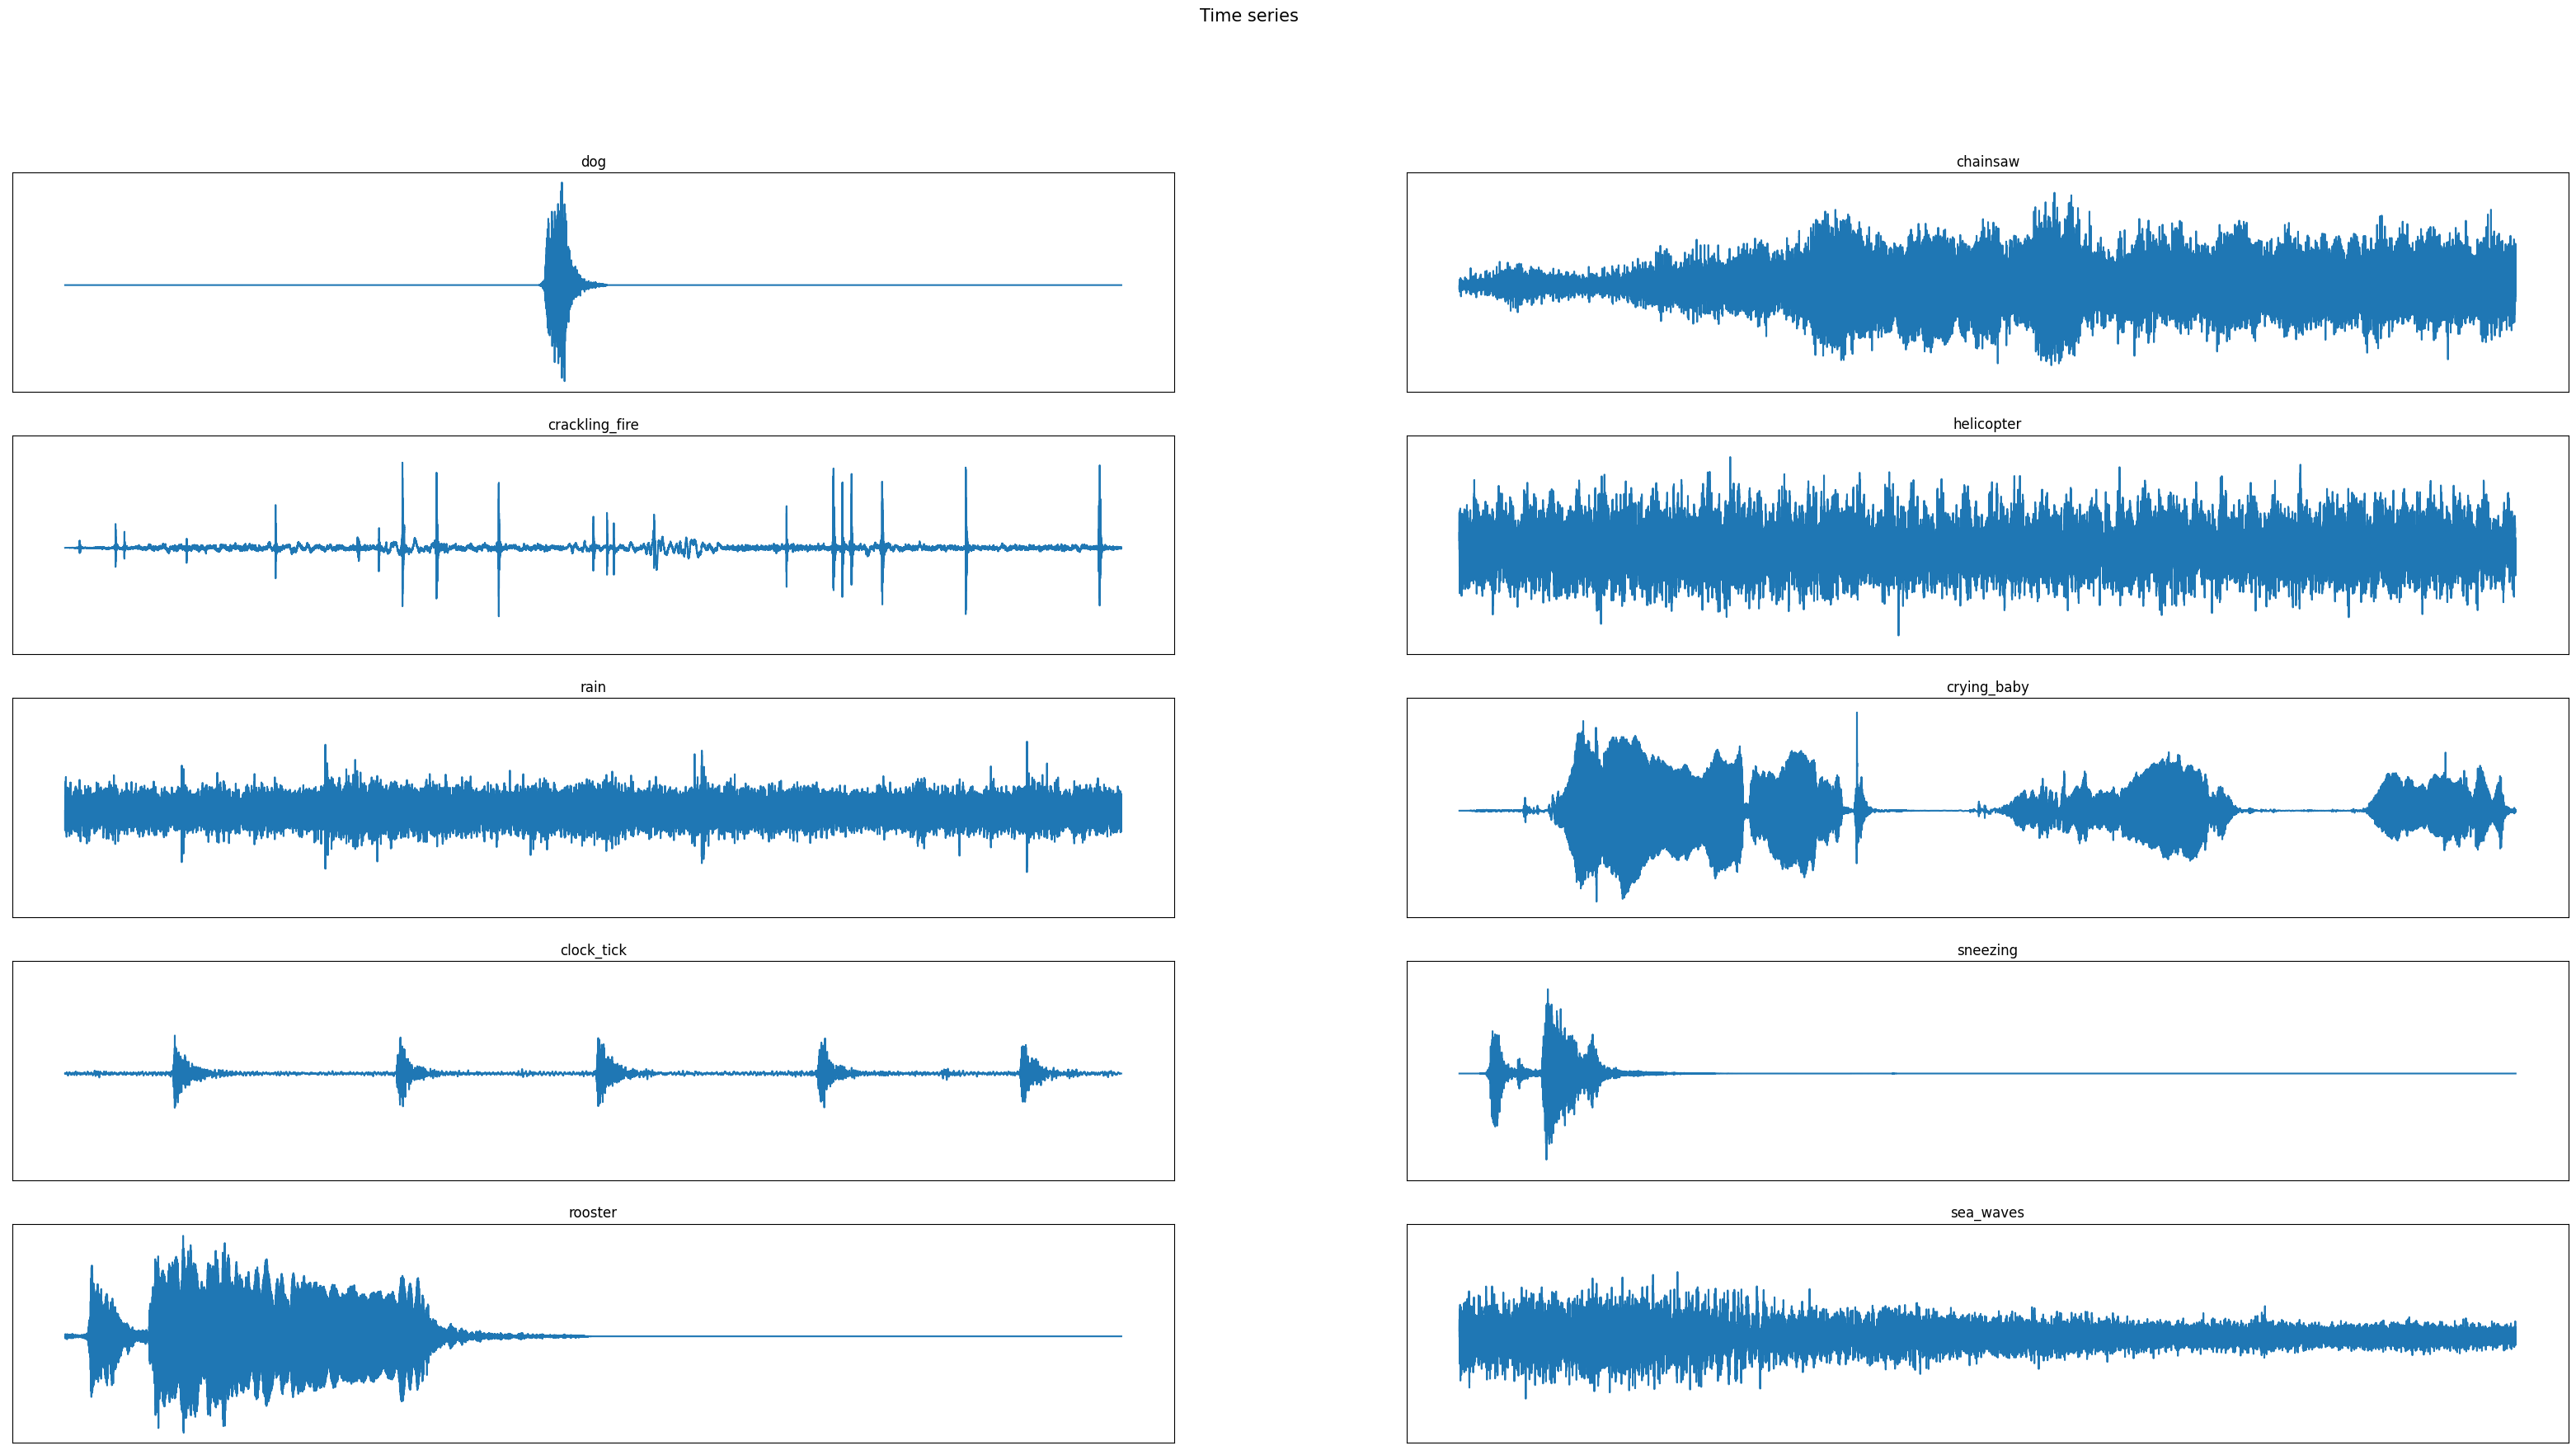

In [14]:
plot_signal(signals)

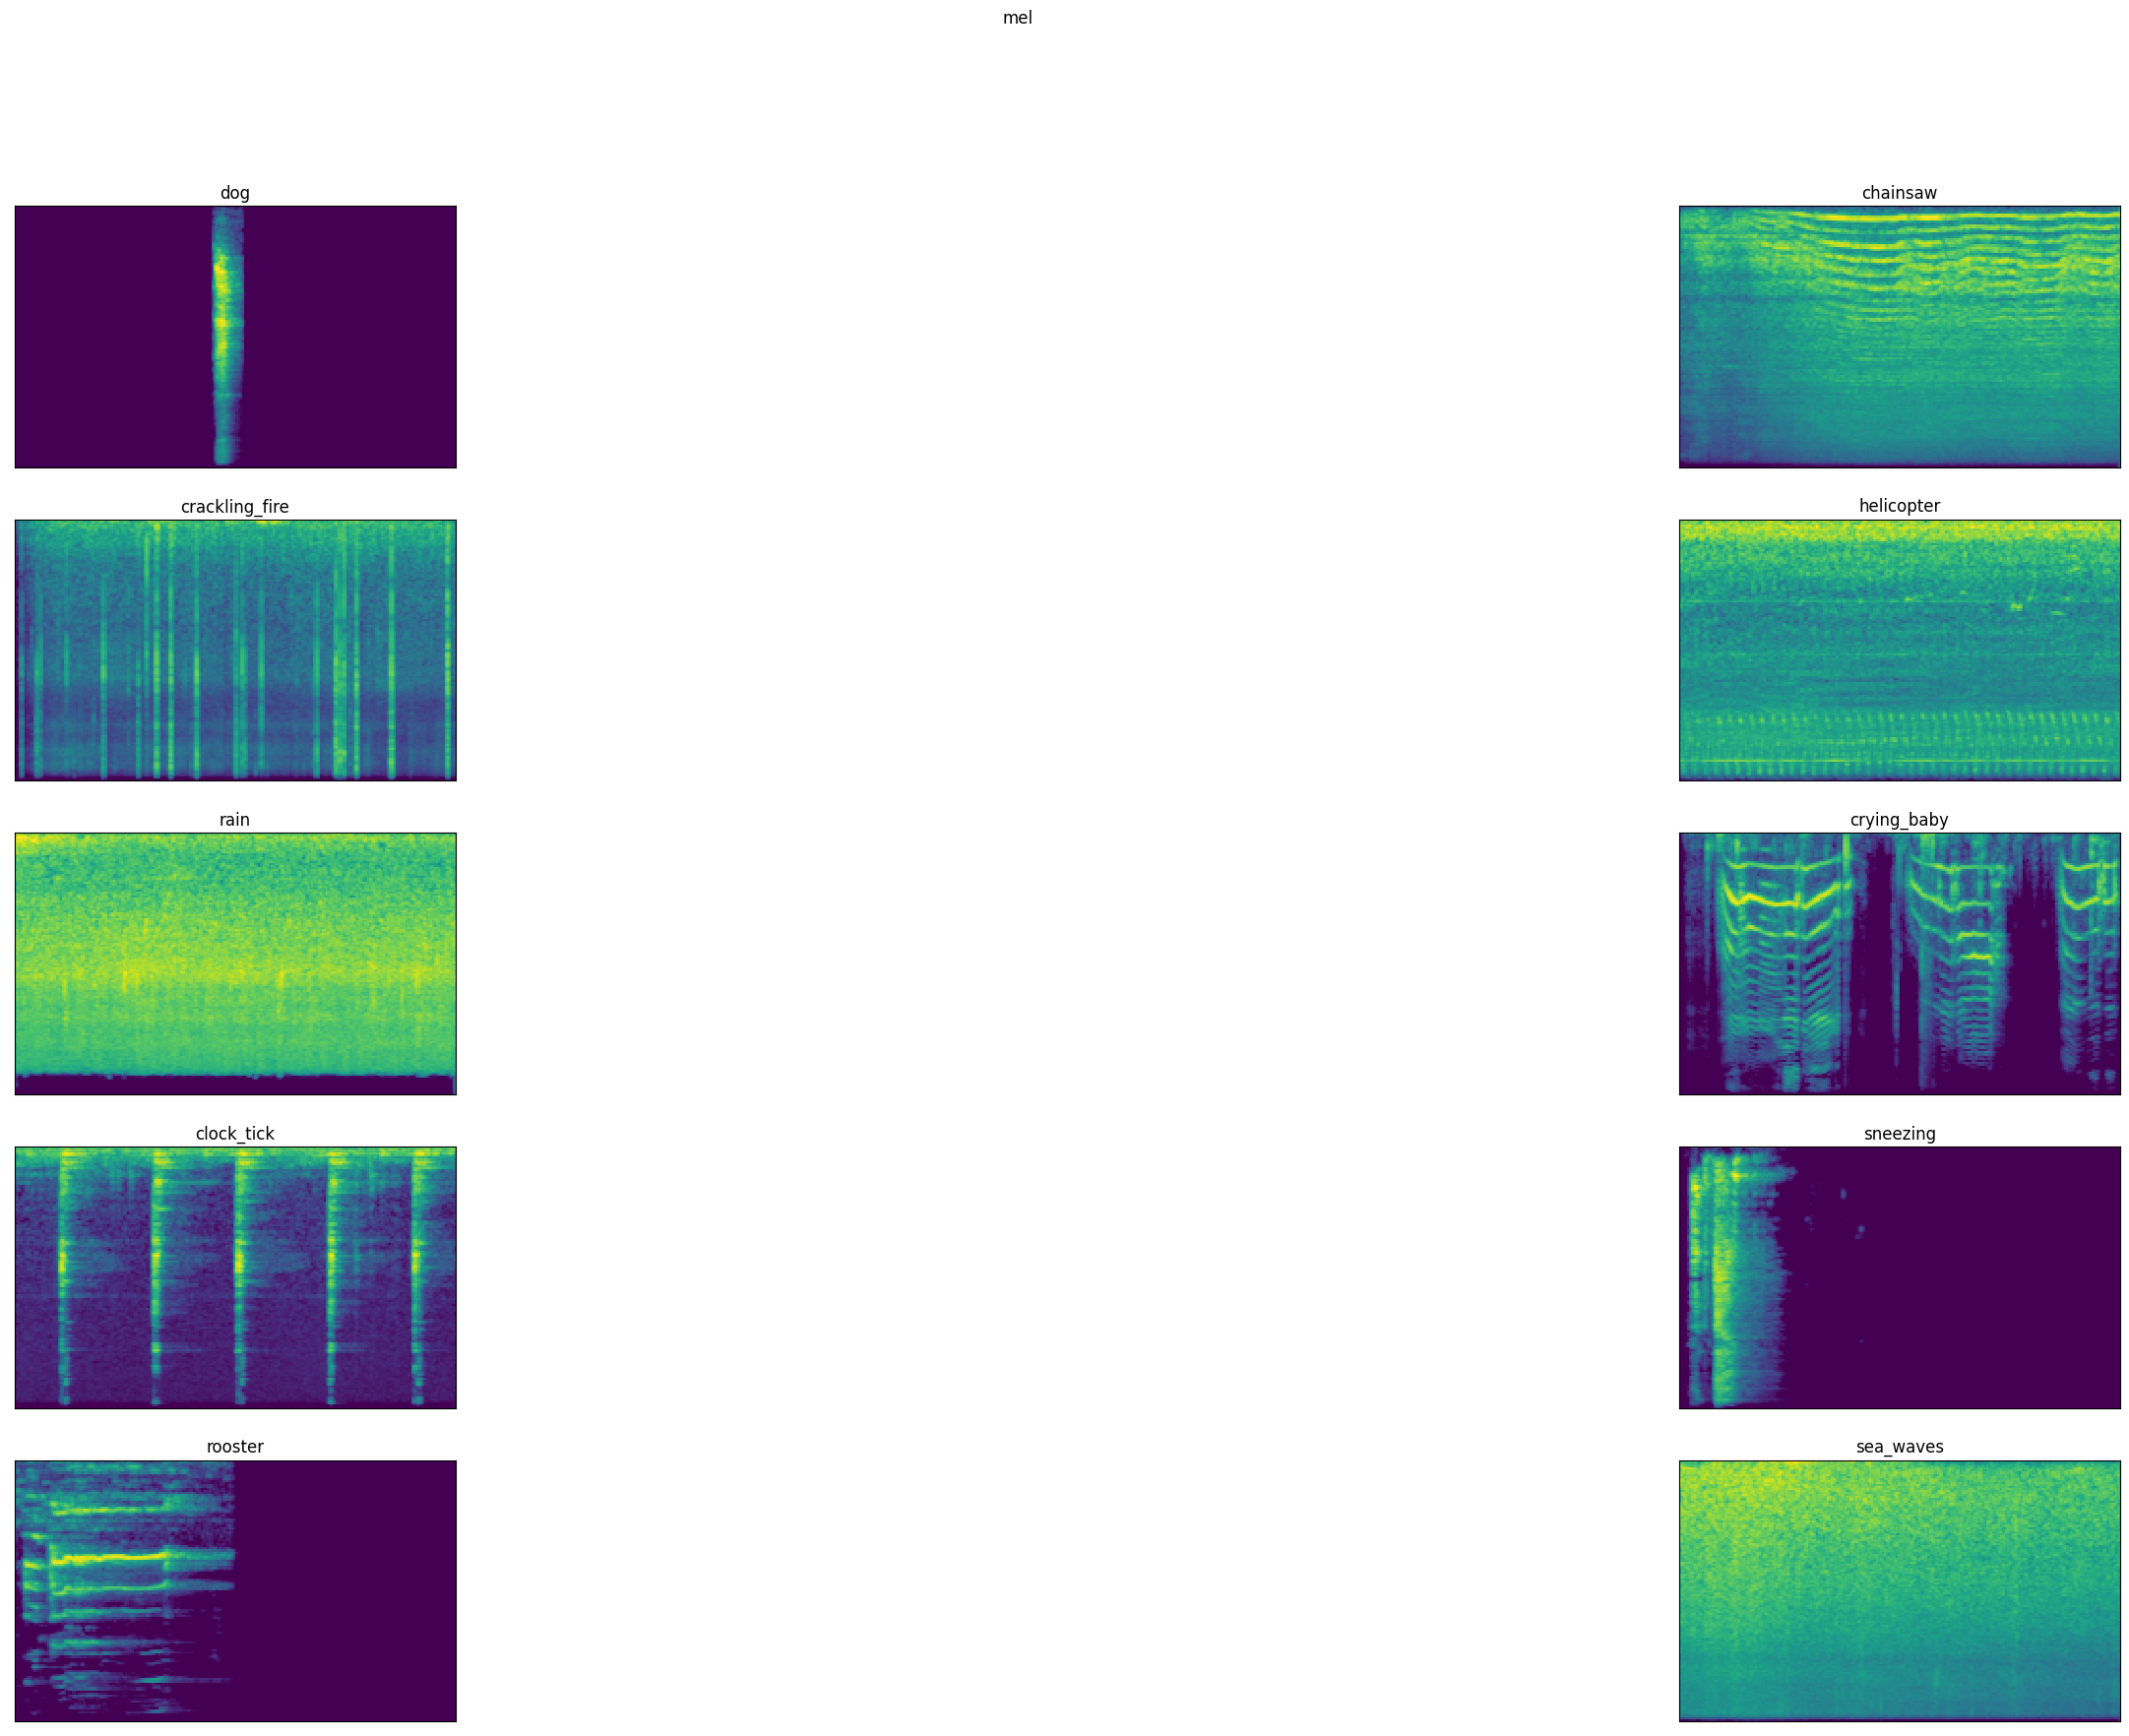

In [15]:
dis_feature(mel_spectrograms)

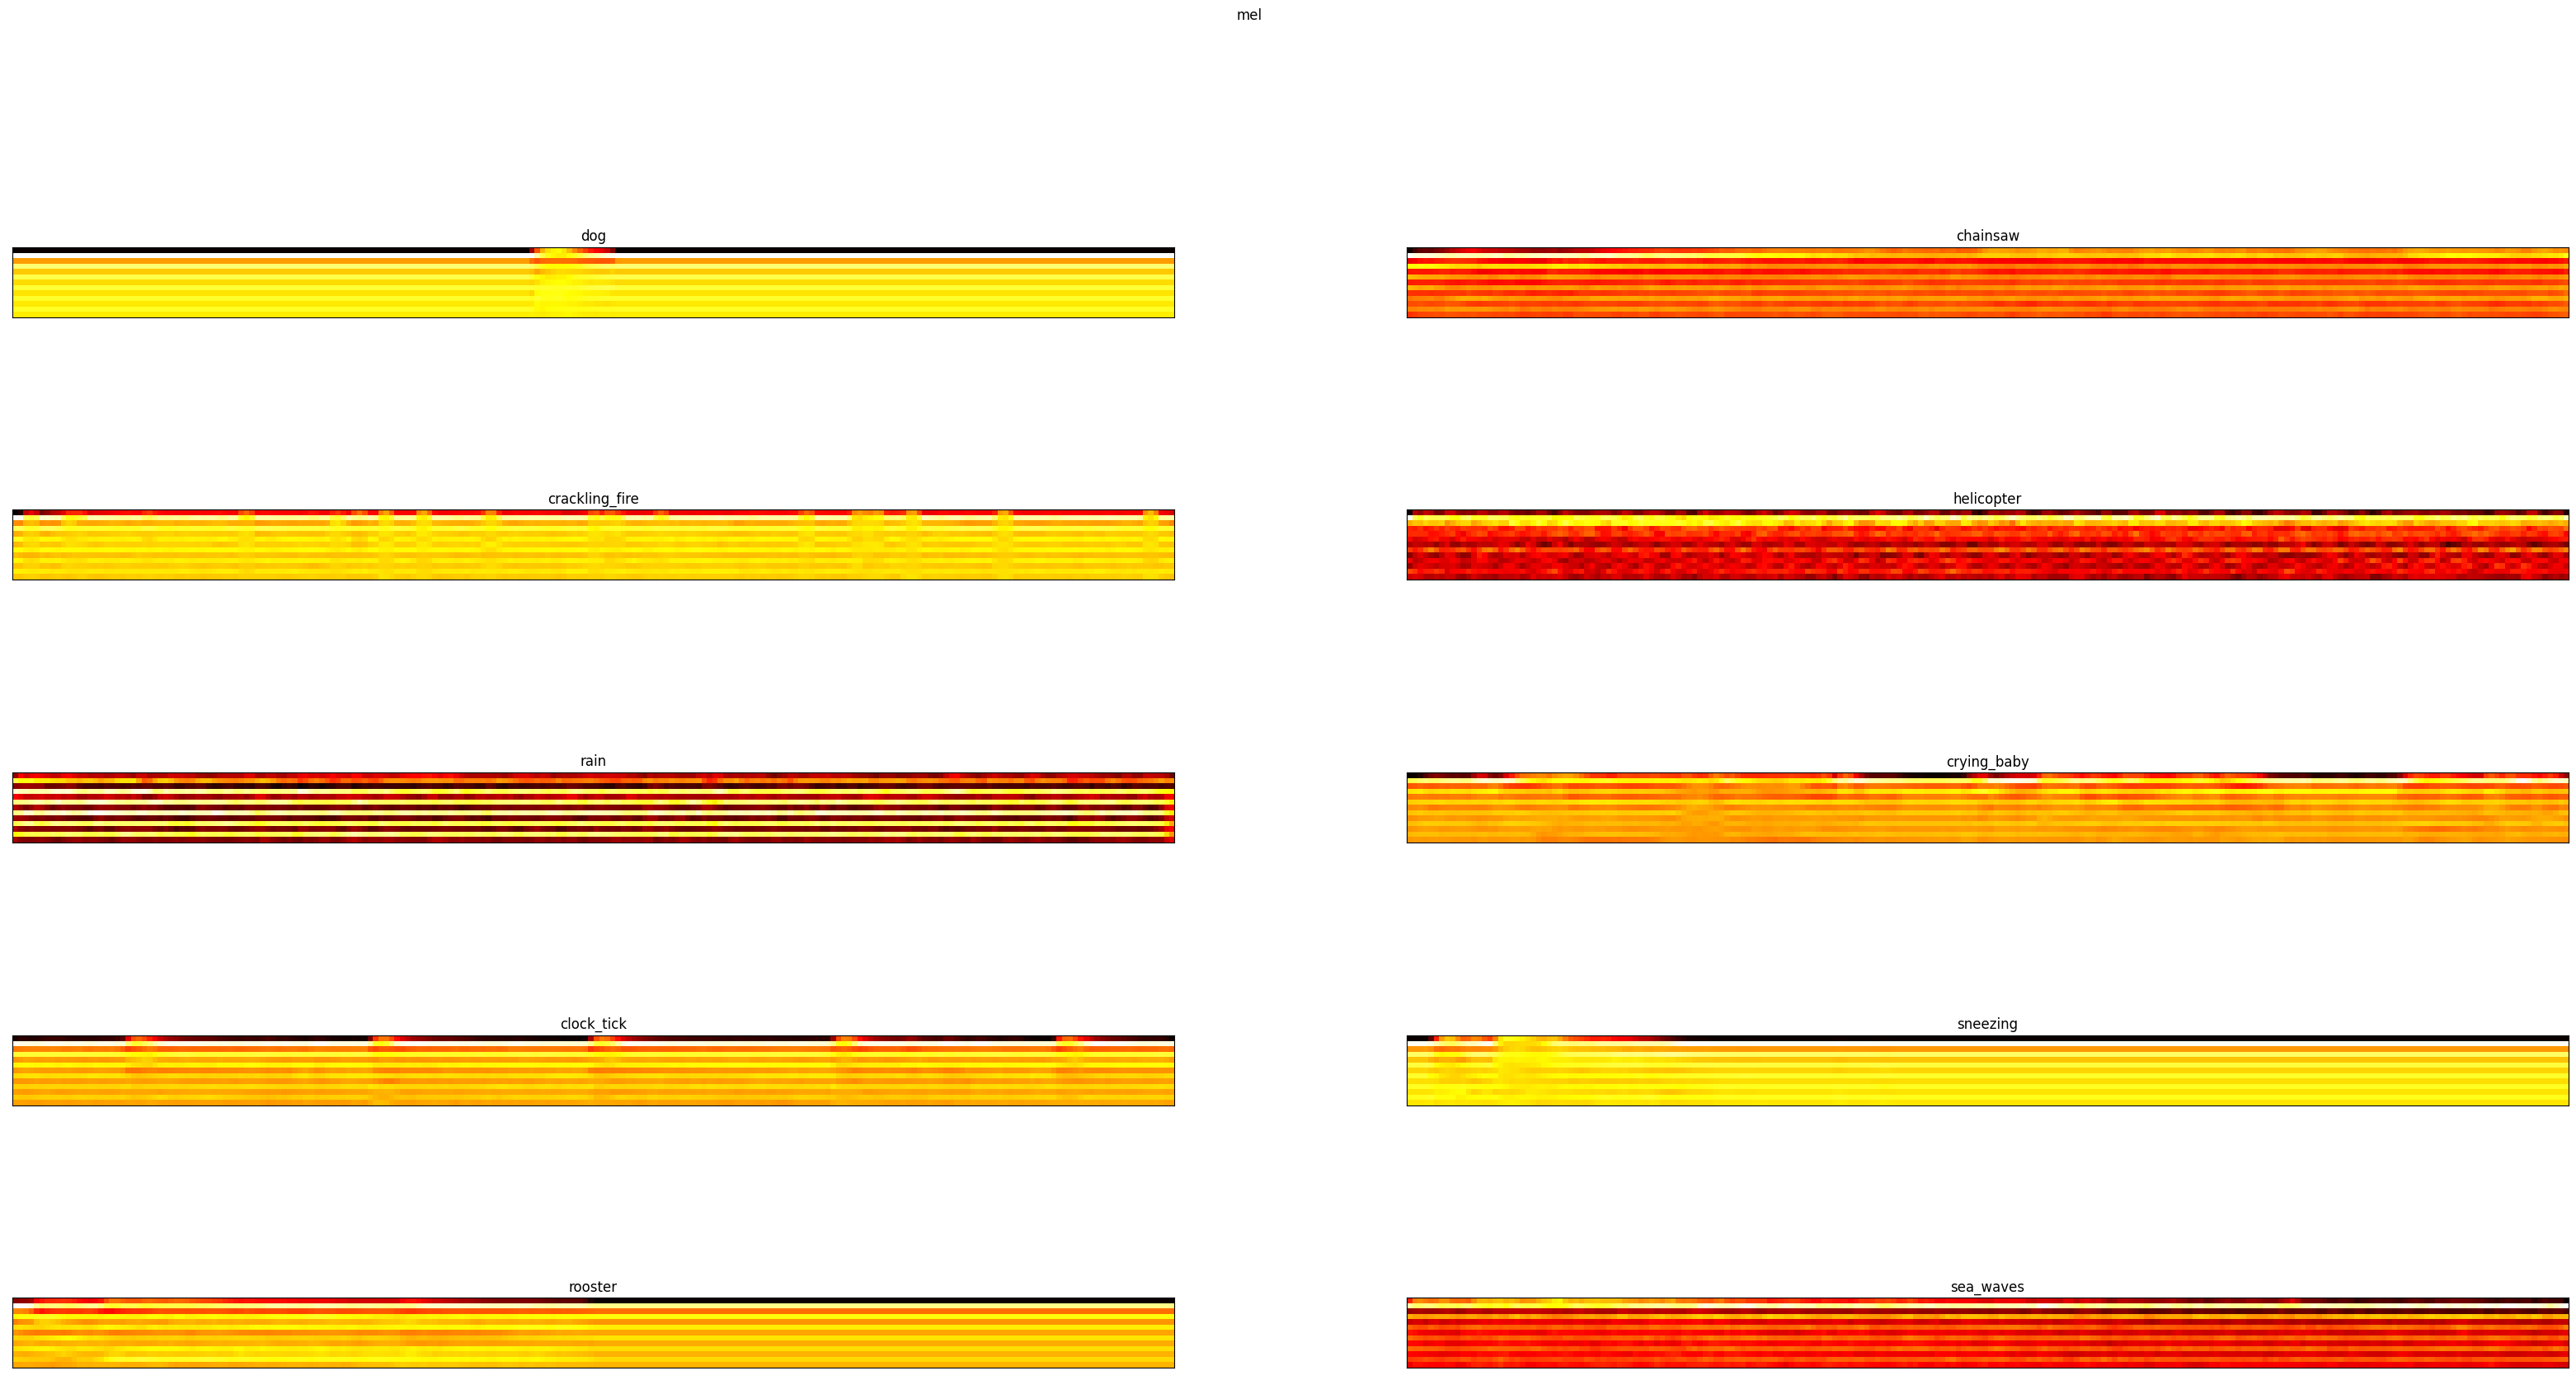

In [16]:
dis_feature(mfccs, cmap='hot')

# Պատրաստում ենք տվյանլները training-ի համար։

In [17]:
X , y = [] , []
for data in tqdm(df_10.iterrows()):
  sig , sr = librosa.load(DATA_PATH+data[1][0])
  for i in range(3):
    n = np.random.randint(0, len(sig)-(sr*2))
    sig_ = sig[n : int(n+(sr*2))]
    mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
    X.append(mfcc_)
    y.append(data[1][1])

X = np.array(X) 
y = np.array(y)

y = tf.keras.utils.to_categorical(y , num_classes=10)

X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

0it [00:00, ?it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[ 0.01934883 -0.02194167 -0.08849649 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
2it [00:00,  8.41it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[ 0.04752741 -0.0205669  -0.04791112 ...  0.02532456  0.09339418
  0.11861624] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[ 0.19910118  0.17764828  0.19861758 ... -0.13842262 -0.10805301
 -0.05794802] as keyword a

11it [00:01,  7.48it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-0.29604325  0.16203065 -0.08302941 ...  0.00135543  0.00248111
 -0.00357526] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-0.01678061 -0.00881789 -0.00364166 ...  0.03138309 -0.04642242
  0.00267094] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[ 0.01696009  0.02008263 -0.03407632 ...  0.01076804  0.00510709
  0.00502389] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
12it [00:01,  7.53it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-0.0032802  -0.002874

21it [00:02,  7.45it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-0.04465517 -0.06250959 -0.07664473 ... -0.02971382  0.06675903
  0.17309906] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-0.05642319 -0.08416862 -0.03972185 ...  0.01593399  0.04250302
  0.03285509] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-0.01181261 -0.03097959 -0.04266861 ... -0.17634448  0.10545429
  0.20625816] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
22it [00:02,  7.49it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-0.02755109 -0.034831

31it [00:04,  7.47it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-0.29457384 -0.29272473 -0.24119233 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[ 0.1680788   0.0441168  -0.09054151 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
32it [00:04,  7.49it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-0.11360194 -0.10232399 -0.05584509 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-0.03474826 -0.13281839 -0.20458768 ...  0.  

42it [00:05,  7.51it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-0.02078382 -0.01761844 -0.02743056 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-0.00816293 -0.00887033 -0.0062533  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
43it [00:05,  7.59it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[ 0.00370053  0.00407587  0.0043381  ... -0.00379946 -0.00420768
 -0.00379887] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-0.00719907 -0.00753023 -0.00853682 .

52it [00:06,  7.48it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-0.14288215 -0.01370004  0.09873179 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[0.00662183 0.0219358  0.00554449 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-0.00321316  0.01944366  0.04720705 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
53it [00:07,  7.57it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[ 0.08597583  0.07629     0.0657984  ...  0.0

62it [00:08,  7.51it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[ 0.12948525  0.07134533  0.0366463  ...  0.09078095 -0.0519923
 -0.086297  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-0.02420569 -0.01222429  0.06910858 ...  0.01223358  0.02205523
 -0.10850008] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-0.10992896 -0.24407384 -0.0210471  ... -0.01440284 -0.03246295
 -0.1054101 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
63it [00:08,  7.53it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[ 3.8812061e-05  5.4957

72it [00:09,  7.63it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[ 0.05887776  0.06916287  0.07745725 ... -0.1986244  -0.23881036
 -0.32988706] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[0.01147047 0.01140101 0.01153317 ... 0.059669   0.00953277 0.00214056] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-0.01184459 -0.0184062  -0.02094683 ... -0.25451022 -0.21703051
 -0.15044604] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
73it [00:09,  7.62it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[ 0.03457506  0.0129265  -0.0

82it [00:10,  7.54it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[ 0.03547952  0.07295843  0.153427   ... -0.0275774   0.06122973
  0.03028095] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-0.02819154 -0.05832702 -0.06850412 ... -0.04384651 -0.07112146
 -0.06353363] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-0.04059182 -0.11861482 -0.20331873 ... -0.01908069 -0.0104653
  0.043856  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
83it [00:10,  7.54it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[ 0.00034026 -0.0001789

92it [00:12,  7.45it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-0.00104102 -0.00149057  0.00126766 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-0.0002415  -0.0003556  -0.00039422 ...  0.17076951  0.16795442
  0.06413619] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[1.9357946e-04 2.5188024e-04 8.1548824e-05 ... 5.5437337e-04 8.9301332e-04
 6.0047110e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
93it [00:12,  7.37it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-3.051758e-05 -3.

102it [00:13,  7.55it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-0.00188126 -0.00185697 -0.00174512 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
103it [00:13,  7.57it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[ 1.4660553e-03  1.3045669e-03  1.1903661e-03 ...  5.2187038e-06
 -1.1797153e-04  1.5746757e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[0.00273786 0.00289422 0.00322061 ... 0.00114794 0.00130133 0.00132217] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-0.0035405  -0.0

112it [00:14,  7.67it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-5.6455965e-06 -2.6653477e-03 -2.0927850e-03 ... -1.6171711e-03
 -3.1545430e-03 -2.4636094e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[ 0.0002397   0.00083984 -0.00189089 ...  0.00454152  0.0019921
  0.00068375] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-0.00150139 -0.00074544 -0.00152284 ...  0.00020039  0.00117146
  0.00044392] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
113it [00:14,  7.96it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-0

122it [00:16,  7.55it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[ 0.0035699   0.00377192  0.00347257 ... -0.00793594 -0.01835752
 -0.01544496] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[ 0.00202506  0.00105381  0.00033861 ... -0.00444347 -0.00465589
 -0.00460531] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-0.00104465 -0.00124943 -0.00283516 ... -0.00334573 -0.00200598
 -0.00154654] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
123it [00:16,  7.53it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-0.011599   -0.0085

132it [00:17,  7.51it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[ 0.03324575  0.03732963  0.03773294 ... -0.06468876 -0.07068296
 -0.0844984 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[ 0.03594963  0.02932203 -0.01658316 ... -0.00466713 -0.00991969
 -0.01809796] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[0.4366355  0.29568478 0.24488056 ... 0.01605087 0.02562599 0.01830584] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
133it [00:17,  7.55it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[0.04837935 0.03633448 0.00

142it [00:18,  7.63it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[ 0.03457051  0.01481446 -0.00422834 ...  0.0007753   0.00093693
  0.00085975] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[ 8.4279716e-05 -2.0248228e-04 -2.9621710e-04 ... -2.4661314e-02
 -4.7311995e-02 -7.9783984e-02] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-0.00026603  0.00013905  0.00049381 ...  0.12046881  0.09551858
  0.0563268 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
143it [00:18,  7.59it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-

152it [00:20,  7.41it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[0.00042725 0.00042725 0.00042725 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[0.0010376 0.0010376 0.0010376 ... 0.        0.        0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[ 0.08187044  0.01567161 -0.12076947 ...  0.00012207  0.00012207
  0.00012207] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
153it [00:20,  7.46it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[ 2.3917604e-02  2.1220887e-02 -1.232858

162it [00:21,  7.48it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-0.0194279   0.00390579  0.00034395 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[0.12721258 0.07993724 0.11321075 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
163it [00:21,  7.45it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-1.7846049e-01 -3.5117015e-02  1.2633967e-01 ... -3.8196940e-05
 -3.0330854e-04 -3.6713399e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[0.02714745 0.059

172it [00:22,  7.50it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[0.06287722 0.05873816 0.05629982 ... 0.07509437 0.06969079 0.05992779] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-0.20086823 -0.20192997 -0.2101314  ... -0.0567829  -0.03769678
 -0.02369107] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-0.04506663 -0.05019655 -0.05844536 ... -0.17622562 -0.17967805
 -0.18156134] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
173it [00:22,  7.51it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[0.01595207 0.08180928 0.15

182it [00:24,  7.48it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-5.8219521e-03 -6.3788355e-03 -5.3459313e-03 ...  7.0901471e-08
  4.9609821e-07 -1.1624866e-06] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-0.00079181 -0.00171322 -0.00107311 ... -0.00037684 -0.00045427
  0.00043731] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-0.01275128 -0.01250724 -0.01265344 ...  0.00169503  0.00138845
  0.0023238 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
183it [00:24,  7.49it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-

192it [00:25,  7.55it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-0.01426658  0.00034364  0.00936088 ...  0.01448003  0.01519927
  0.02162683] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-0.04227563 -0.04431179 -0.04964981 ... -0.00417796 -0.00724847
 -0.00272377] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[ 0.02593635  0.03651158  0.03688808 ... -0.02067208 -0.00410553
 -0.00537873] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
193it [00:25,  7.55it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-0.02287677 -0.0307

203it [00:26,  7.46it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[0.01838315 0.00873158 0.01561692 ... 0.04483196 0.05201761 0.05210336] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-3.0517582e-05 -3.0517582e-05 -3.0517582e-05 ...  2.9938599e-01
  2.3056123e-01  1.3292332e-01] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-0.30538294 -0.07145284  0.21219073 ...  0.00068447  0.00058796
  0.00075402] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
204it [00:27,  7.50it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-0.17165

213it [00:28,  7.47it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-0.01627317  0.02631569  0.04066901 ... -0.07578622 -0.08356698
 -0.10736788] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-0.25469595 -0.20853887 -0.16715978 ...  0.05564971  0.09880888
  0.06725874] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[ 0.01745567  0.02535801  0.0360309  ... -0.24323156 -0.2681146
 -0.19695276] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
214it [00:28,  7.48it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-0.0017395 -0.001739

224it [00:29,  7.59it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-0.12514627 -0.08802036 -0.06465221 ...  0.1131454   0.12277808
  0.09439012] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[ 0.06305539  0.16483535  0.29370734 ... -0.24159034 -0.20758176
 -0.28954756] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-0.01065886 -0.02245898 -0.01584353 ...  0.14993355  0.17219469
  0.14014836] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
225it [00:29,  7.57it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-0.00082741 -0.0008

234it [00:31,  7.12it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[ 0.00951434  0.01958037  0.02279538 ...  0.01847369  0.01768696
 -0.03558831] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-0.504663   -0.60331917 -0.65817136 ... -0.00431616 -0.0054795
 -0.00572011] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[ 0.05974333  0.05207193 -0.05934212 ...  0.00308346  0.00313642
  0.00285178] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
235it [00:31,  7.05it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-0.01650932 -0.04600

244it [00:32,  7.13it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[ 0.06144069 -0.02998749 -0.04011365 ... -0.15690692 -0.18740505
 -0.21380362] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-0.00638917 -0.00713166 -0.00693406 ...  0.00194399  0.00067507
 -0.00052307] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[0.05021264 0.03649216 0.03938062 ... 0.04372811 0.01018031 0.18192205] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
245it [00:32,  7.21it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[2.6491404e-02 3.3432402e-0

254it [00:33,  7.17it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-0.00686066  0.03330296  0.05576744 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[0.00228881 0.00228891 0.00228862 ... 0.00198823 0.00377496 0.00356107] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-0.06519307 -0.09834637 -0.09340919 ...  0.00122065  0.00122078
  0.00122062] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
255it [00:34,  7.22it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-1.1958600e-02  1.1450619e-02  6.3

264it [00:35,  7.41it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-0.04105119 -0.05460862 -0.07397388 ... -0.17116107 -0.18791412
 -0.18983069] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[ 0.03761439  0.0393191   0.06224854 ... -0.02233073 -0.03944698
 -0.07216284] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[ 0.08092773  0.14589322  0.17299724 ... -0.05025356 -0.04036885
 -0.07635794] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
265it [00:35,  7.48it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-0.08393355 -0.1130

275it [00:36,  6.87it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[0.01944917 0.01981564 0.01937419 ... 0.00857424 0.01052324 0.00696167] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[ 0.01954901  0.02217957  0.02067844 ... -0.11698543 -0.11631568
 -0.11756209] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[ 0.04173737  0.04185095  0.04203178 ... -0.05196608 -0.05191217
 -0.05151203] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
276it [00:37,  6.92it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[0.06252082 0.06936505 0.07

285it [00:38,  7.66it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[ 4.4321299e-05  2.4800807e-05 -2.5901127e-06 ...  6.1115786e-04
  6.1739841e-04  6.1031757e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[3.5092602e-05 6.2841893e-05 1.4652815e-04 ... 1.9942767e-03 2.2041504e-03
 2.5590293e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[ 8.9350513e-05  9.3141862e-05  8.6577915e-05 ... -2.1708735e-04
 -2.7671762e-04 -3.0721957e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
286it [00:38,  7.29it/s]/tmp/ipykernel_9409/3560599967.

296it [00:39,  7.37it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[ 0.0002509   0.00020927  0.00020846 ... -0.04773562 -0.05719222
 -0.07221376] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-3.03688983e-04 -5.74959377e-05 -1.02556885e-04 ... -9.42818369e-05
 -6.01271968e-05  1.91815761e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-2.6620596e-04 -2.7177631e-04 -2.9410276e-04 ...  4.2348361e-01
  4.6448264e-01  4.9659196e-01] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
297it [00:39,  7.36it/s]/tmp/ipykernel_9409/3560599967.py:7: 

306it [00:41,  7.45it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-2.5649846e-04  1.9636759e-06  8.2503923e-04 ...  6.6464738e-04
  2.3519364e-04 -8.1862810e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-0.00049337 -0.00066868 -0.00059431 ...  0.12996869  0.1269306
  0.1313942 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[ 0.00709097  0.00765437  0.00836227 ... -0.11066815 -0.0796416
 -0.05180179] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
307it [00:41,  7.20it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-0.

316it [00:42,  7.47it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-0.00023909 -0.00076157 -0.00065862 ... -0.00571447 -0.00397837
 -0.00187109] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-0.00022655 -0.0010539  -0.00142503 ...  0.00279994  0.00312177
  0.00284699] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[ 3.2761346e-03  2.0101106e-02  3.0480392e-02 ... -1.6420598e-05
 -5.7481080e-05 -9.1195558e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
317it [00:42,  7.52it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-

326it [00:43,  7.36it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[0.00620496 0.01851322 0.02831019 ... 0.17125984 0.14562406 0.15074368] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[0.18037942 0.17075287 0.17309031 ... 0.10738156 0.0954515  0.08983201] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-0.02117049 -0.00971075 -0.01591855 ... -0.22937727 -0.1997677
 -0.2237566 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
327it [00:43,  7.45it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[0.04786951 0.04501289 0.03400828 .

336it [00:45,  7.53it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[ 3.0271118e-04  5.7833582e-05 -7.8128476e-05 ...  3.0752699e-04
  2.7979593e-04  1.7276259e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-0.0009299  -0.00081701 -0.00074018 ... -0.00101214 -0.00099062
 -0.00111038] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[ 0.00139973  0.00143041  0.00126902 ... -0.0003308  -0.00020656
 -0.00027177] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
337it [00:45,  7.35it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[ 

346it [00:46,  7.44it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[ 0.06849983  0.0504088  -0.04308715 ...  0.0214723  -0.00295066
  0.00482687] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[ 0.12585886  0.19881828  0.15432458 ...  0.05191715 -0.00779807
 -0.01124915] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[ 0.0294368   0.05719865  0.099349   ... -0.09916621 -0.14840227
 -0.13324   ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
347it [00:46,  7.50it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-0.00808123 -0.0125

356it [00:47,  7.67it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-0.00766382 -0.00732814 -0.00376813 ... -0.00050054 -0.0007276
 -0.00208261] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[0.00512946 0.0061815  0.00588607 ... 0.15152095 0.15014534 0.11958807] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-0.00064097  0.00121822  0.00332716 ... -0.15043771 -0.07224089
 -0.0206031 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
357it [00:47,  7.69it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-0.07255214 -0.05746104 -0.

366it [00:49,  7.70it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[0.03754484 0.00494597 0.00075783 ... 0.28752214 0.28923365 0.26555938] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[ 0.3502696   0.3745749   0.4065206  ... -0.18929273 -0.2110308
 -0.2360718 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[ 0.23167025  0.2376238   0.18941638 ... -0.12490973 -0.12735711
 -0.1402372 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
367it [00:49,  7.71it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-0.0197368  -0.02668286 -0.

375it [00:50,  7.73it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-0.00768983 -0.00554424 -0.00566915 ... -0.00030559 -0.00054408
 -0.00073308] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[ 0.15673877  0.14437962  0.12930489 ... -0.01397886 -0.01679397
 -0.01968289] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[0.00677885 0.00884649 0.00831265 ... 0.00185802 0.00178852 0.00140784] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
376it [00:50,  7.69it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[ 0.05722728  0.05216618  0

385it [00:51,  7.62it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[ 0.0268772   0.01084544  0.00886831 ...  0.07994054 -0.00885943
  0.0117451 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[0.04355017 0.03501535 0.05652595 ... 0.07135732 0.02991557 0.01596425] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-0.02047477 -0.02108843 -0.0131164  ...  0.0853218   0.15670498
  0.1221479 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
386it [00:51,  7.66it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[0.03079047 0.02895974 0.02

396it [00:53,  7.69it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[0.00331059 0.01036388 0.01156045 ... 0.11228096 0.09836534 0.06250305] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-0.09265906 -0.0782456  -0.07551441 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[ 0.015262    0.01595144  0.0161112  ...  0.00133326 -0.03058945
 -0.07978463] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
397it [00:53,  7.67it/s]/tmp/ipykernel_9409/3560599967.py:7: FutureWarning: Pass y=[-0.10099889  0.00284958  0.0702952

In [18]:
X.shape
y.shape

(1200, 13, 87, 1)

(1200, 10)

In [19]:
x_train , x_val , y_train , y_val = train_test_split(X , y ,test_size=0.2, random_state=2020)

# Մոդելներ

In [20]:
INPUTSHAPE = (13,87,1)

In [21]:
model =  models.Sequential([
                          layers.Conv2D(16 , (3,3),activation = 'relu',padding='valid', input_shape = INPUTSHAPE),
                          layers.Conv2D(16, (3,3), activation='relu',padding='valid'),

                          layers.Conv2D(32, (3,3), activation='relu',padding='valid'),
                          layers.Conv2D(32, (3,3), activation='relu',padding='valid'),

                          layers.Conv2D(64, (3,3), activation='relu',padding='valid'),
                          layers.Conv2D(32, (3,3), activation='relu',padding='valid'),
                          layers.GlobalAveragePooling2D(),


                          layers.Dense(32 , activation = 'relu'),
                          layers.Dense(10 , activation = 'softmax')
])

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = 'acc')

2022-11-30 19:35:21.933784: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-30 19:35:21.933946: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-30 19:35:21.934003: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-11-30 19:35:21.934051: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-11-30 19:35:21.934099: W tensorflow/c

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 11, 85, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 83, 16)         2320      
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 81, 32)         4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 5, 79, 32)         9248      
                                                                 
 conv2d_4 (Conv2D)           (None, 3, 77, 64)         18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 1, 75, 32)         18464     
                                                                 
 global_average_pooling2d (G  (None, 32)               0

In [23]:
%mkdir "cpkt"
%mkdir "logs"

mkdir: cannot create directory ‘cpkt’: File exists
mkdir: cannot create directory ‘logs’: File exists


In [24]:
LOGDIR = "logs"
CPKT = "cpkt/"

In [25]:
#Պաշտպանում է overfit լինելուց
callback_1 = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)

#Պահում է լավագույն քաշը ամեն ժամանակ
callback_2 = tf.keras.callbacks.ModelCheckpoint(
    CPKT, monitor='val_loss', verbose=0, save_best_only=True,
    save_weights_only=True, mode='auto', save_freq='epoch', options=None
)

#tensboard-ի համար է
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=LOGDIR)

In [26]:
history = model.fit(x_train,y_train ,
            validation_data=(x_val,y_val),
            epochs=100,
            callbacks = [callback_1 , callback_2 , tensorboard_callback])

Epoch 1/100
30/30 [==============================] - 2s 33ms/step - loss: 1.8481 - acc: 0.3052 - val_loss: 1.4954 - val_acc: 0.3917
Epoch 2/100
30/30 [==============================] - 1s 29ms/step - loss: 1.2720 - acc: 0.5479 - val_loss: 1.0700 - val_acc: 0.6708
Epoch 3/100
30/30 [==============================] - 1s 29ms/step - loss: 1.0594 - acc: 0.6156 - val_loss: 0.9962 - val_acc: 0.7000
Epoch 4/100
30/30 [==============================] - 1s 30ms/step - loss: 0.8520 - acc: 0.7125 - val_loss: 0.8251 - val_acc: 0.7375
Epoch 5/100
30/30 [==============================] - 1s 30ms/step - loss: 0.7081 - acc: 0.7500 - val_loss: 0.8993 - val_acc: 0.7167
Epoch 6/100
30/30 [==============================] - 1s 37ms/step - loss: 0.6595 - acc: 0.7729 - val_loss: 0.7065 - val_acc: 0.7958
Epoch 7/100
30/30 [==============================] - 1s 33ms/step - loss: 0.5612 - acc: 0.8083 - val_loss: 0.7897 - val_acc: 0.7542
Epoch 8/100
30/30 [==============================] - 1s 33ms/step - loss: 0.

In [27]:
%tensorboard --logdir="logs"

In [28]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

import os
import multiprocessing


pool = multiprocessing.Pool(processes = 10)
results_of_processes = [pool.apply_async(os.system, args=(cmd, ), callback = None )
                        for cmd in [
                        f"tensorboard --logdir=\"logs\" --host 0.0.0.0 --port 6006 &",
                        "./ngrok http 6006 &"
                        ]]

--2022-11-30 19:35:37--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.202.168.65, 54.237.133.81, 18.205.222.128, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.202.168.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.19M  1.33MB/s    in 11s     

2022-11-30 19:35:49 (1.15 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13832437/13832437]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [30]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://ae87-141-136-88-216.ngrok.io
